In [1]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2


from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [15:30:59] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
# import master data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


In [3]:
### Import curated datasets:

e_coli_wild_perm = pd.read_pickle('data_curated/e_coli_wild_perm.pkl')
e_coli_wild_efflux = pd.read_pickle('data_curated/e_coli_wild_efflux.pkl')
e_coli_wild = pd.read_pickle('data_curated/e_coli_wild.pkl')
e_coli_s_aureus = pd.read_pickle('data_curated/e_coli_s_aureus.pkl')

# import substrate and evader

efflux_substrate = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_efflux']>65)&(e_coli_wild_efflux['INHIB_AVE_wild']<65)]

efflux_evader = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')
rest_of_ecoli_efflux= pd.read_pickle('data_curated/rest_of_ecoli_efflux.pkl')


### Import MMPA result:

# efflux_mmpa_index = pd.read_csv('out/index_co_add_wild_efflux_final.csv')

efflux_mmpa_index = pd.read_pickle('data_curated/efflux_mmpa_index.pkl')

efflux_mmpa_index_len_stat = pd.read_pickle('data_curated/efflux_mmpa_index_len_stat.pkl')

ecoli_wild_index=pd.read_csv('data_curated/index_inhib_wild_final.csv')


## relevant transforms:

substrate_transforms = pd.read_pickle('data_curated/substrate_transforms.pkl')

evader_transforms = pd.read_pickle('data_curated/evader_transforms.pkl')



In [21]:
# z-score:

e_coli_wild_perm['wild_stds'] = stats.zscore(e_coli_wild_perm.INHIB_AVE_wild)
e_coli_wild_perm['lpxc_stds'] = stats.zscore(e_coli_wild_perm.INHIB_AVE_lpxC)

In [22]:
threshold = 4

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_perm['wild_class'] = e_coli_wild_perm.apply(label_it, axis=1)

In [23]:
def label_it(row):
    if row['lpxc_stds'] >=threshold:
        return 'active'
    if row['lpxc_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_perm['lpxc_class'] = e_coli_wild_perm.apply(label_it, axis=1)

In [25]:
e_coli_wild_perm.lpxc_class.value_counts()

inactive    80030
active        590
Name: lpxc_class, dtype: int64

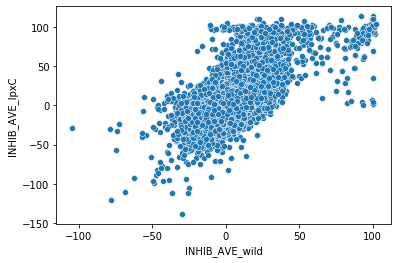

In [20]:
sns.scatterplot(data = e_coli_wild_perm, x = 'INHIB_AVE_wild', y = 'INHIB_AVE_lpxC')

In [28]:
def label_substrate(row):
    if row['lpxc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'OM Impermeable'
    if row['lpxc_class'] == 'active' and row['wild_class'] == 'active':
        return 'OM Permeable'
    if row['lpxc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['lpxc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'
    
e_coli_wild_perm['Class'] = e_coli_wild_perm.apply(label_substrate, axis=1)

In [29]:
e_coli_wild_perm.Class.value_counts()

Inactive          79980
OM Impermeable      369
OM Permeable        221
WT-only Active       50
Name: Class, dtype: int64

In [40]:
e_coli_wild_perm[e_coli_wild_perm.wild_stds >3.99 ].sort_values(by='wild_stds')

,SMILES,INHIB_AVE_wild,INHIB_AVE_lpxC,wild_stds,lpxc_stds,wild_class,lpxc_class,Class
28505,N1(C(=O)CSC1=N)c2sccn2,41.87,69.96,3.995366,4.589510,inactive,active,OM Impermeable
54750,c(cc(Br)cc1Cl)(\C=N\c2c(O)ccc(C(C)CCC)c2)c1O,42.08,70.44,4.017441,4.623752,active,active,OM Permeable
55601,c1(C#N)c(COC)cc(nc1SCC[N+](C)(C)CC(=O)Nc(cccc2...,42.19,58.64,4.029003,3.781967,active,inactive,WT-only Active
71825,c12c(c(cc(C)n1)C)c(c(cc(C)cc3C)c3n2)N,42.19,70.84,4.029003,4.652287,active,active,OM Permeable
38545,Nc1nc(F)nc2n(cnc12)[C@@H]1O[C@H](CO)[C@@H](O)[...,42.20,41.83,4.030055,2.582781,active,inactive,WT-only Active
...,...,...,...,...,...,...,...,...
30861,N1(CCCCCCCCCC)C=CC(C=C1)=N.Br,101.08,92.79,10.219294,6.218149,active,active,OM Permeable
23724,CCN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)C1CC1,101.15,100.21,10.226652,6.747475,active,active,OM Permeable
73795,c1c(C=[N+](CCO)/[O-])oc([N+](=O)[O-])c1,101.33,101.04,10.245573,6.806685,active,active,OM Permeable
23441,CC(N([H])C(=O)C1N([H])C(=O)c2nc(c(nc2)cc3)cc3)...,101.44,90.80,10.257136,6.076187,active,active,OM Permeable


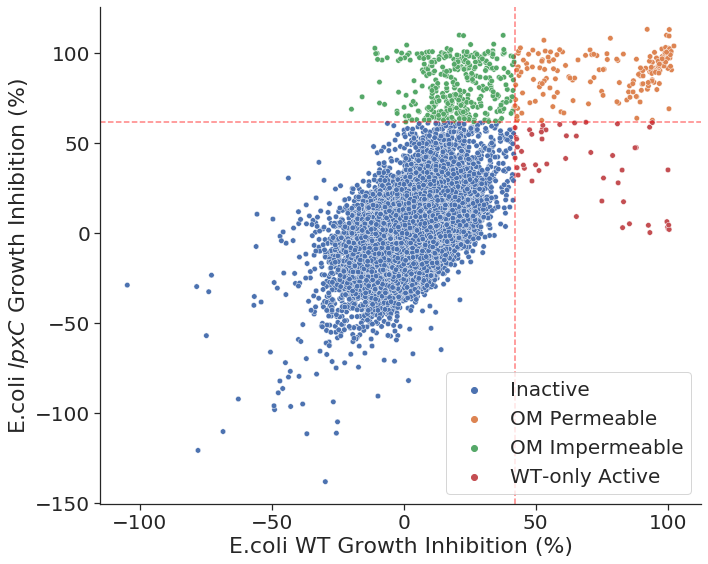

In [43]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])

sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style("ticks")

sns.scatterplot(data = e_coli_wild_perm, x='INHIB_AVE_wild', y='INHIB_AVE_lpxC', hue='Class', s=30)

sns.despine()

plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('E.coli WT Growth Inhibition (%)', fontsize=22);

plt.ylabel('E.coli $lpxC$ Growth Inhibition (%)',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axvline(x=42.08,  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=61.83,  color='red', linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('figures/wild_lpxc_class_scatter.png', dpi=600)